# Classification of Pet's Real-Life Images

Now it's time to deal with more challenging task - classification of the original [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Let's start by loading and visualizing the dataset.

In [1]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
!tar xfz oxpets_images.tar.gz
!rm oxpets_images.tar.gz

--2022-02-17 08:43:09--  https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘oxpets_images.tar.gz’

oxpets_images.tar.g 100%[===================>] 755.23M  16.5MB/s    in 49s     

2022-02-17 08:43:59 (15.3 MB/s) - ‘oxpets_images.tar.gz’ saved [791918971/791918971]



We will define generic function to display a series of images from a list:

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

You can see that all images are located in one directory called `images`, and their name contains the name of the class (breed):

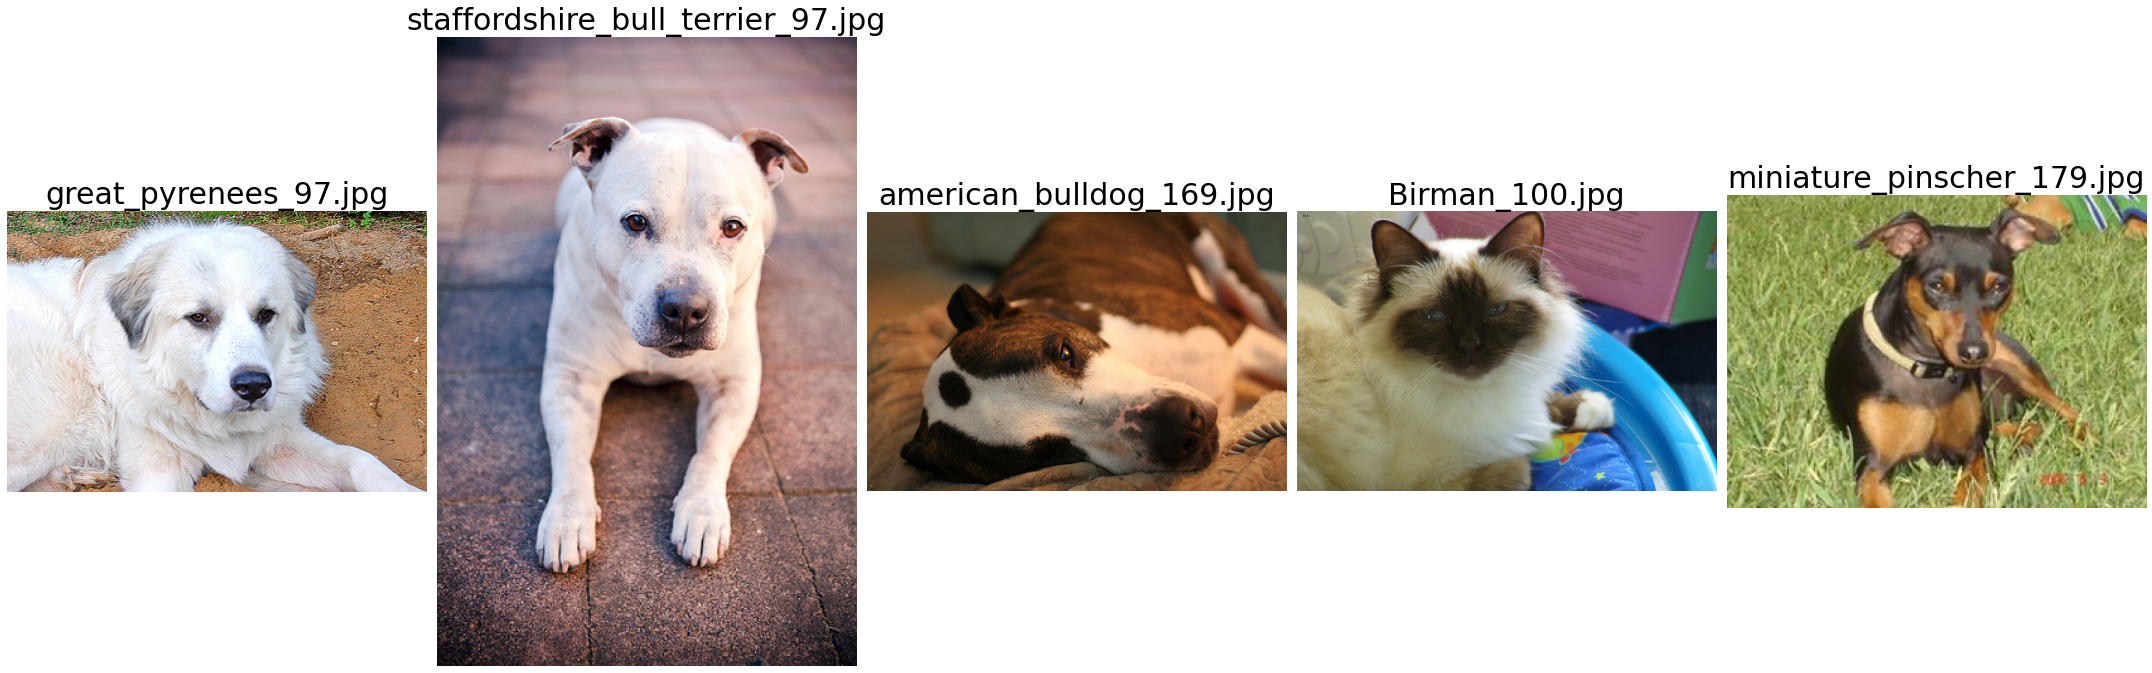

In [7]:
fnames = os.listdir('images')[:5]
display_images([Image.open(os.path.join('images',x)) for x in fnames],titles=fnames,fontsize=30)

To simplify classification and use the same approach to loading images as in the previous part, let's sort all images into corresponding directories:

In [15]:
for fn in os.listdir('images'):
    cls = fn[:fn.rfind('_')].lower()
    os.makedirs(os.path.join('images',cls),exist_ok=True)
    os.replace(os.path.join('images',fn),os.path.join('images',cls,fn))

Let's also define the number of classes in our dataset:

In [16]:
num_classes = len(os.listdir('images'))
num_classes

37

## Preparing dataset for Deep Learning

To start training our neural network, we need to convert all images to tensors, and also create tensors corresponding to labels (class numbers). Most neural network frameworks contain simple tools for dealing with images:
* In Tensorflow, use `tf.keras.preprocessing.image_dataset_from_directory`
* In PyTorch, use `torchvision.datasets.ImageFolder`

As you have seen from the pictures above, all of them are close to square image ratio, so we need to resize all images to square size. Also, we can organize images in minibatches.

> Since we are going to use pre-trained neural networks that have been trained on ImageNet images of size 224x224, we will resize our images to this size.

In [53]:
import tensorflow as tf

image_size = 224
batch_size = 32

train, test = [
    tf.keras.preprocessing.image_dataset_from_directory(
    'images',
    image_size=(image_size,image_size),
    # crop_to_aspect_ratio=True,
    validation_split=0.2,
    subset=s,
    batch_size=batch_size,
    seed=13)
    for s in ['training','validation']]

class_names = train.class_names


Found 7390 files belonging to 37 classes.
Using 5912 files for training.
Found 7390 files belonging to 37 classes.
Using 1478 files for validation.


Now let's print the size of tensors in our dataset. If you have done everything correctly, the size of training elements should be
 * `(batch_size,image_size,image_size,3)` for Tensorflow, `batch_size,3,image_size,image_size` for PyTorch
 * `batch_size` for Labels
 
 Labels should contain numbers of classes.

In [54]:
for i,l in train:
    print(i.shape,l.shape)
    print(l)
    print('Max intensity = ',np.max(i))
    break

(32, 224, 224, 3) (32,)
tf.Tensor(
[ 9 14 21 15 20 25 31 19 35 22  8 18  7 26 29 27 15  5 21  6 17  5 17 29
  8 10  2  3 18 34 20 34], shape=(32,), dtype=int32)
Max intensity =  255.0


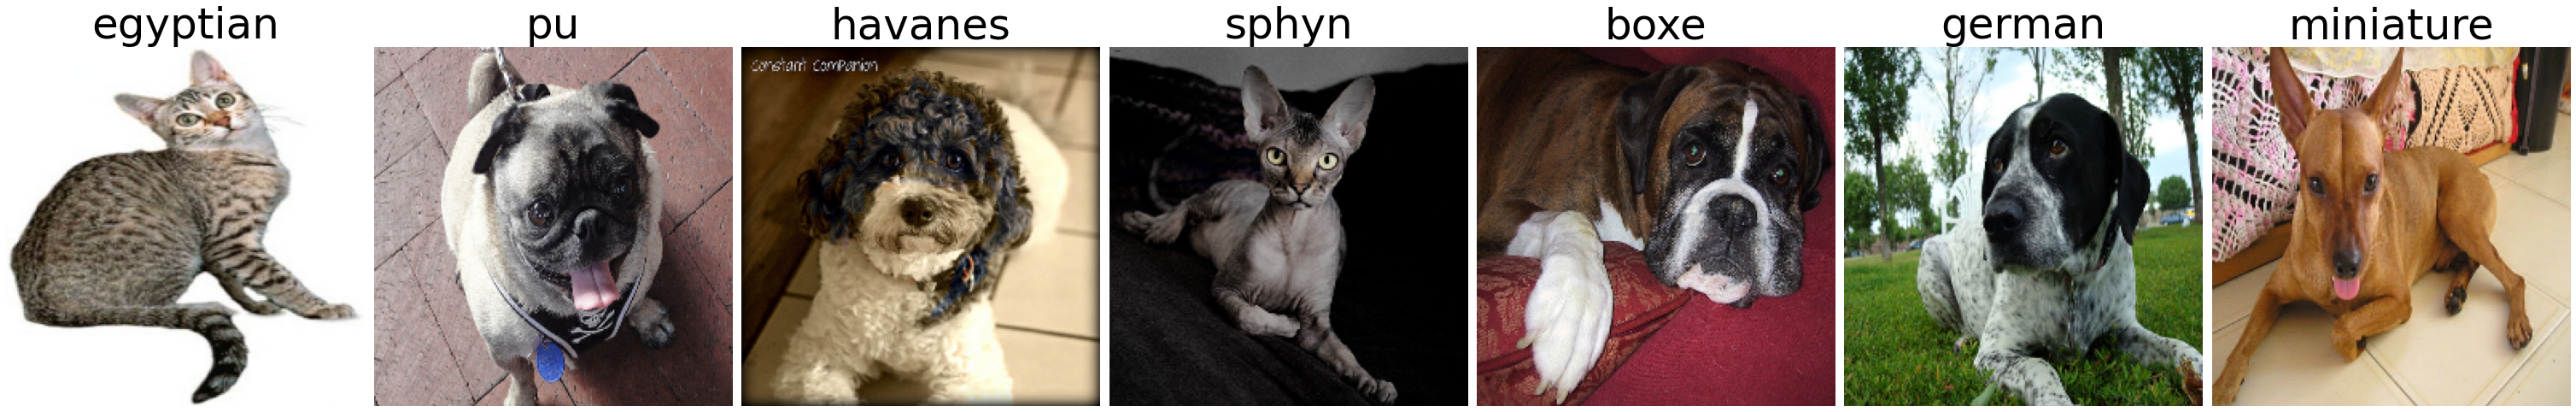

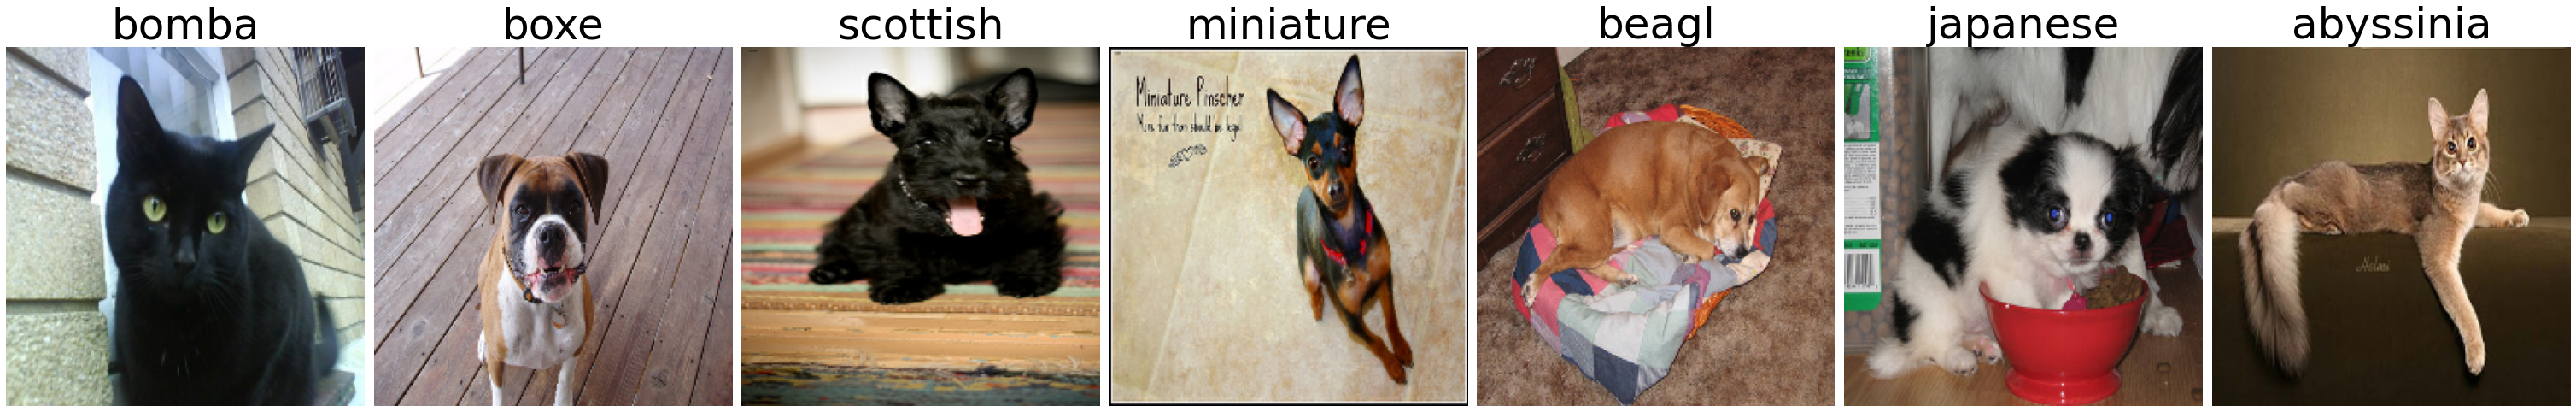

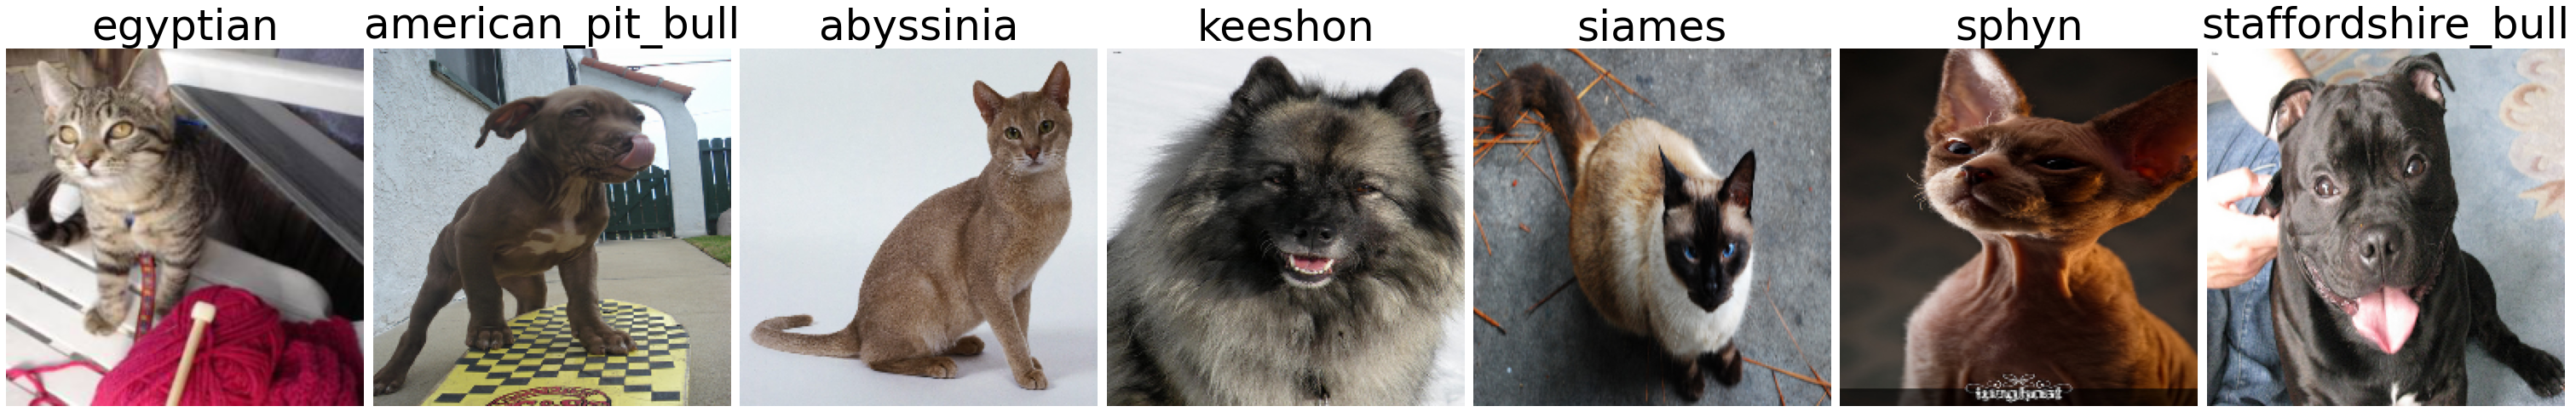

In [25]:
for _,(i,l) in zip(range(3),train):
    display_images(i[:7]/255.,titles=[train.class_names[x] for x in l[:7]],fontsize=50)

> See that images are resized without taking aspect ratio into account. If you want to keep the aspect ratio, use `crop_to_aspect_ratio=True` flag.

You also need to make sure that all input data is normalized between 0 and 1. In some cases (if you have used `ToTensor` transform in PyTorch), this is already the case, while in others you need to do it manually.

In [55]:
train_norm = train.map(lambda i,c : (i/255.0,c))
test_norm = test.map(lambda i,c : (i/255.0,c))

## Define a neural network

For image classification, you should probably define a convolutional neural network with several layers. What to keep an eye for:
* Keep in mind the pyramid architecture, i.e. number of filters should increase as you go deeper
* Do not forget activation functions between layers (ReLU) and Max Pooling
* Final classifier can be with or without hidden layers, but the number of output neurons should be equal to number of classes.

An important thing is to get the activation function on the last layer + loss function right:
* In Tensorflow, you can use `softmax` as the activation, and `sparse_categorical_crossentropy` as loss. The difference between sparse categorical cross-entropy and non-sparse one is that the former expects output as the number of class, and not as one-hot vector.
* In PyTorch, you can have the final layer without activation function, and use `CrossEntropyLoss` loss function. This function applies softmax automatically.

> **Hint:** In PyTorch, you can use `LazyLinear` layer instead of `Linear`, in order to avoid computing the number of inputs. It only requires one `n_out` parameter, which is number of neurons in the layer, and the dimension of input data is picked up automatically upon first `forward` pass.

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(image_size,image_size,3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

## Train the Neural Network

Now we are ready to train the neural network. During training, please collect accuracy on train and test data on each epoch, and then plot the accuracy to see if there is overfitting.

In [28]:
hist = model.fit(train_norm,validation_data=test_norm,epochs=10)

Epoch 1/10
185/185 [==============================] - 89s 472ms/step - loss: 3.6020 - acc: 0.0477 - val_loss: 3.2075 - val_acc: 0.1340
Epoch 2/10
185/185 [==============================] - 98s 525ms/step - loss: 2.7736 - acc: 0.2425 - val_loss: 3.3561 - val_acc: 0.1576
Epoch 3/10
185/185 [==============================] - 98s 526ms/step - loss: 1.5947 - acc: 0.5478 - val_loss: 4.8761 - val_acc: 0.1421
Epoch 4/10
185/185 [==============================] - 99s 527ms/step - loss: 0.6379 - acc: 0.8261 - val_loss: 6.6454 - val_acc: 0.1461
Epoch 5/10
185/185 [==============================] - 99s 530ms/step - loss: 0.1762 - acc: 0.9587 - val_loss: 8.1247 - val_acc: 0.1576
Epoch 6/10
185/185 [==============================] - 99s 528ms/step - loss: 0.1152 - acc: 0.9716 - val_loss: 9.1885 - val_acc: 0.1448
Epoch 7/10
185/185 [==============================] - 99s 529ms/step - loss: 0.0873 - acc: 0.9792 - val_loss: 9.9961 - val_acc: 0.1549
Epoch 8/10
185/185 [==============================] - 9

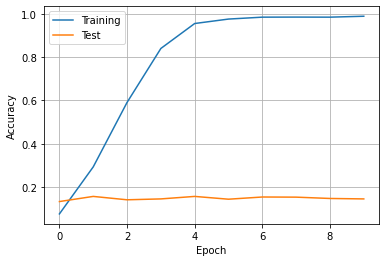

In [29]:
plt.plot(hist.history['acc'],label='Training')
plt.plot(hist.history['val_acc'],label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looks like the accuracy is far from great!

## Transfer Learning

To improve the accuracy, let's use pre-trained neural network as feature extractor. Feel free to experiment with VGG-16/VGG-19 models, ResNet50, etc.

> **Note**: When running in the Microsoft Learn sandbox, access to arbitrary Internet resources is limited. Therefore, we need to download ResNet weights and explicitly specify the filename when creating the nework. When running notebook somewhere else, you can remove `wget` code and `weights` parameter.

In [ ]:
!wget https://mslearntensorflowlp.blob.core.windows.net/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
resnet = tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),
             weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

Now we will define one neural network that will consist of the following layers:

* Pre-processing layer that handles initial normalization of input images according to ResNet conventions
* ResNet feature extractor defined above
* Final classification layer (or several layers) 

> Since this training is slower, you may start with training the model for the small number of epochs, eg. 3. You can alsways resume training to further improve accuracy if needed.

In [60]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
model.add(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

model.layers[1].trainable = False

In [61]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')
hist = model.fit(train,validation_data=test,epochs=3)

Epoch 1/3
185/185 [==============================] - 249s 1s/step - loss: 10.8459 - acc: 0.5877 - val_loss: 7.0390 - val_acc: 0.7936
Epoch 2/3
185/185 [==============================] - 245s 1s/step - loss: 1.7655 - acc: 0.9324 - val_loss: 7.1437 - val_acc: 0.8031
Epoch 3/3
185/185 [==============================] - 245s 1s/step - loss: 0.6529 - acc: 0.9701 - val_loss: 6.4506 - val_acc: 0.8457


It seems much better now!

## Optional: Calculate Top3 Accuracy

We can also computer Top3 accuracy using the same code as in the previous exercise.

In [62]:
correct = 0
total = 0
for t,l in test:
    r = model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=3)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

tf.Tensor(0.9675236806495264, shape=(), dtype=float64)
